# Lab 02: Similitud de Imágenes con Codificadores DinoV2

## Objetivos
1. **Codificadores de Imágenes**: Cómo usar DinoV2 para codificar imágenes en vectores de características.
2. **Métricas de Similitud**: Cómo evaluar la similitud entre imágenes codificadas usando similitud coseno.
3. **Recuperación de Imágenes**: Cómo encontrar las imágenes más similares en un conjunto de datos.
4. **Métricas de evaluación**: Cómo evaluar los resultados obtenidos por la recuperación de imágenes (mAP).

## Conjunto de Datos
Trabajaremos con el conjunto de datos Pepeganga (creado inhouse en nuestro CVLab), que contiene imágenes de productos de varias categorías (juguetes, electrónica, artículos del hogar, deportes, etc.).

## Parte 1: Configuración y Carga de Datos

Primero, importaremos las bibliotecas necesarias y cargaremos nuestro conjunto de datos.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import os

from torchvision import transforms
from sklearn.preprocessing import normalize
from PIL import Image
from tqdm import tqdm
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [ ]:
# Descargar el archivo zip desde Google Drive
!gdown --id 11-TD6add7zZaukIB8l2cVnBTJgsTjo8n

# Descomprimir el archivo
!unzip dataset_ecom_mini.zip

# Cargar los metadatos del conjunto de datos
data_dir = Path('eval')
df = pd.read_csv('eval.csv', delimiter=';')

print(f"El conjunto de datos contiene {len(df)} imágenes")
print(f"\nDistribución de categorías:")
print(df['GlobalCategoryEN'].value_counts())

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11-TD6add7zZaukIB8l2cVnBTJgsTjo8n
To: /content/dataset_ecom_mini.zip
100% 10.6M/10.6M [00:00<00:00, 22.3MB/s]
Archive:  dataset_ecom_mini.zip
replace eval/45elec.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: El conjunto de datos contiene 300 imágenes

Distribución de categorías:
GlobalCategoryEN
Toy Store                  54
Sports                     37
Technology                 35
Home                       35
Pets                       31
Videogames and Consoles    30
Clothes and Shoes          27
Furniture                  13
Babies                     12
Beauty                      8
School                      8
Christmas Decoration        4
Bedroom                     4
Home Appliances             1
Foods and Dri

## Parte 2: Cargar el Modelo DinoV2

DinoV2 es un transformador de visión auto-supervisado que produce embeddings de imágenes de alta calidad. Usaremos el modelo `dinov2_vits14` (variante pequeña con tamaño de parche 14x14).

In [ ]:
# Cargar el modelo DinoV2 desde torch hub
# https://github.com/facebookresearch/dinov2

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model = model.to(device)
model.eval()

print("¡Modelo DinoV2 cargado exitosamente!")
print(f"Dimensión de salida del modelo: {model.embed_dim}")

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth


100%|██████████| 1.13G/1.13G [00:06<00:00, 192MB/s]


¡Modelo DinoV2 cargado exitosamente!
Dimensión de salida del modelo: 1024


## Parte 3: Preprocesamiento de Imágenes

Definimos el pipeline de preprocesamiento para DinoV2. El modelo espera imágenes normalizadas con estadísticas de ImageNet.

In [ ]:
# Definir la transformación de preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def encode_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(img_tensor)

    return features.cpu().numpy().flatten()

print(encode_image(data_dir / '14toys.jpg').shape)

(1024,)


## Parte 4: Prueba de Similitud Visual con Imágenes de Muestra

Probemos manualmente la similitud comparando algunas imágenes de ejemplo. Seleccionaremos imágenes que visualmente parecen similares y diferentes para verificar que nuestro codificador funciona correctamente.

In [ ]:
# Función auxiliar para calcular similitud coseno
def cosine_similarity(vec1, vec2):
    """
    vec1, vec2: (numpy arrays)
    Puntuación de similitud entre 0 y 1 (1 = idéntico)
    """
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# Función auxiliar para mostrar imágenes lado a lado con sus puntuaciones de similitud.
def display_image_comparison(img_paths, titles, similarities=None):
    """
    img_paths: Lista de rutas de imágenes
    titles: Lista de títulos para cada imagen
    similarities: Lista opcional de puntuaciones de similitud
    """

    n_images = len(img_paths)
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))

    if n_images == 1:
        axes = [axes]

    for idx, (img_path, title) in enumerate(zip(img_paths, titles)):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')

        if similarities and idx > 0:
            axes[idx].set_title(f"{title}\nSimilitud: {similarities[idx-1]:.4f}", fontsize=12)
        else:
            axes[idx].set_title(title, fontsize=12)

    plt.tight_layout()
    plt.show()

Probando imágenes similares (todos juguetes):
Similitud entre imagen 1 y 2: -0.0004
Similitud entre imagen 1 y 3: 0.0450


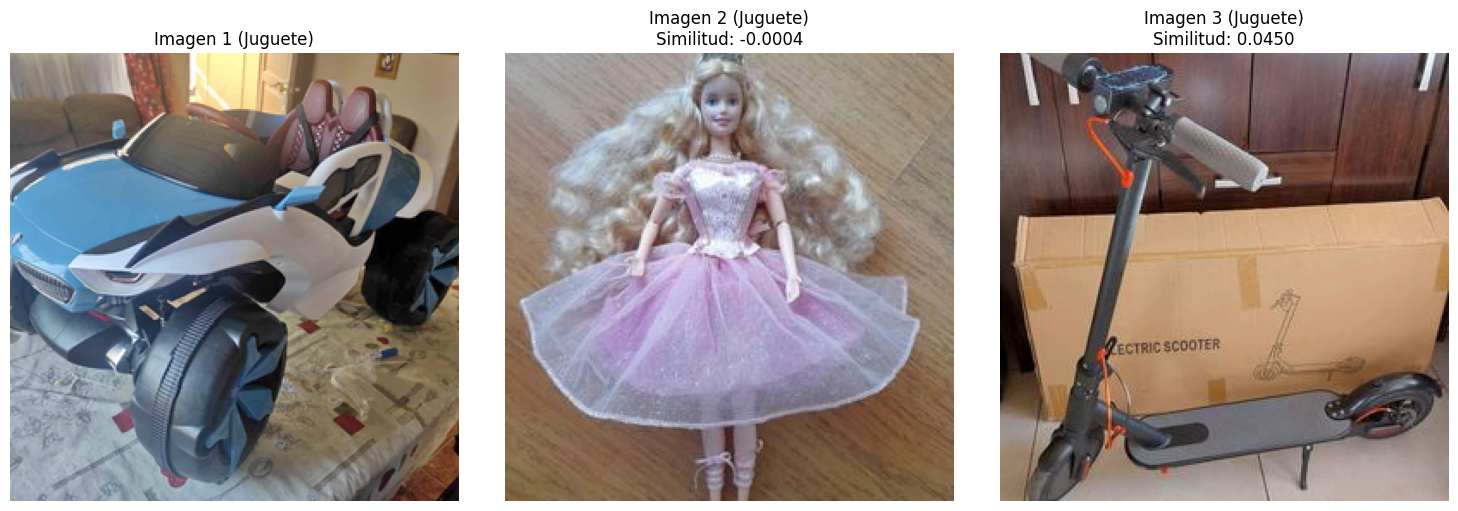

In [ ]:
# Prueba 1: Comparar imágenes similares (misma categoría)

# Seleccionar algunas imágenes de juguetes
img1_path = data_dir / '14toys.jpg'
img2_path = data_dir / '60toys.jpg'
img3_path = data_dir / '74toys.jpg'

# Codificar imágenes
enc1 = encode_image(img1_path)
enc2 = encode_image(img2_path)
enc3 = encode_image(img3_path)

# Calcular similitudes
sim_1_2 = cosine_similarity(enc1, enc2)
sim_1_3 = cosine_similarity(enc1, enc3)

print("Probando imágenes similares (todos juguetes):")
print(f"Similitud entre imagen 1 y 2: {sim_1_2:.4f}")
print(f"Similitud entre imagen 1 y 3: {sim_1_3:.4f}")

display_image_comparison(
    [img1_path, img2_path, img3_path],
    ["Imagen 1 (Juguete)", "Imagen 2 (Juguete)", "Imagen 3 (Juguete)"],
    [sim_1_2, sim_1_3]
)


Probando imágenes diferentes (categorías distintas):
Similitud entre Juguete y Electrónica: 0.0190
Similitud entre Juguete y Deportes: -0.0103


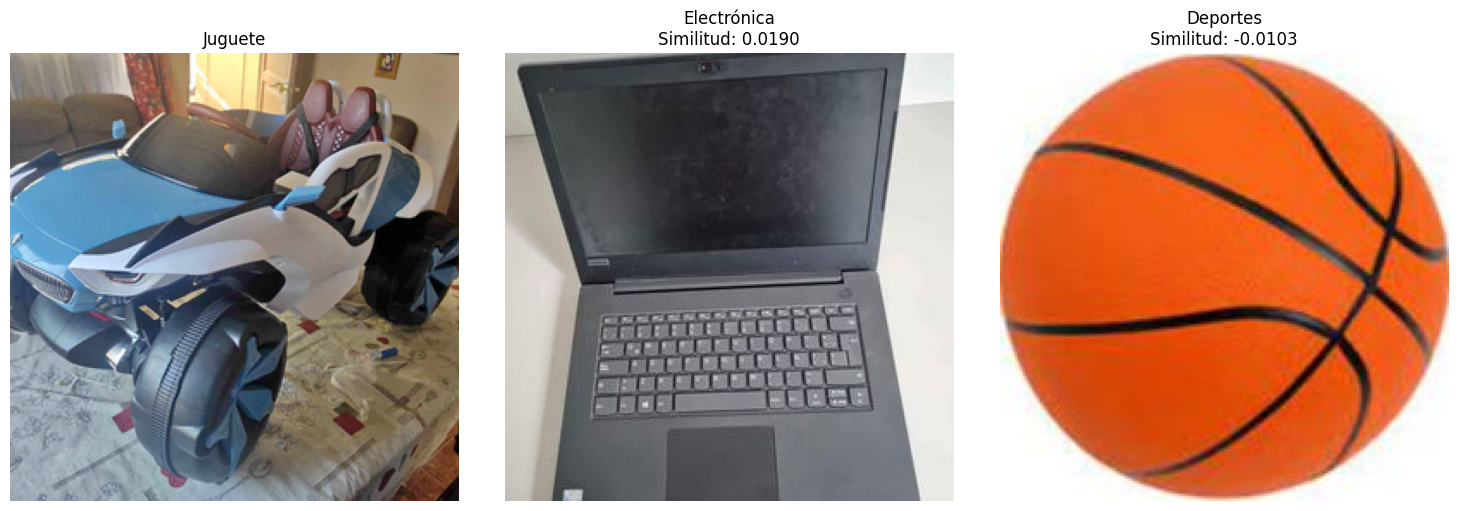

In [ ]:
# Prueba 2: Comparar imágenes diferentes (categorías distintas)
# Comparar un juguete con electrónica y deportes
img_toy = data_dir / '14toys.jpg'
img_elec = data_dir / '411elec.jpg'
img_sports = data_dir / 'im.8yfy47.input.jpg'

# Codificar imágenes
enc_toy = encode_image(img_toy)
enc_elec = encode_image(img_elec)
enc_sports = encode_image(img_sports)

# Calcular similitudes
sim_toy_elec = cosine_similarity(enc_toy, enc_elec)
sim_toy_sports = cosine_similarity(enc_toy, enc_sports)

print("\nProbando imágenes diferentes (categorías distintas):")
print(f"Similitud entre Juguete y Electrónica: {sim_toy_elec:.4f}")
print(f"Similitud entre Juguete y Deportes: {sim_toy_sports:.4f}")

display_image_comparison(
    [img_toy, img_elec, img_sports],
    ["Juguete", "Electrónica", "Deportes"],
    [sim_toy_elec, sim_toy_sports]
)

## Parte 5: Codificar Todas las Imágenes del Conjunto de Datos

Ahora codificaremos todas las imágenes del conjunto de evaluación y almacenaremos sus vectores de características. Esto nos permitirá calcular similitudes entre todos los pares de imágenes.

In [ ]:
# Obtener todos los nombres de archivos de imágenes del dataframe
image_filenames = df['Title'].values
n_images = len(image_filenames)

print(f"Codificando {n_images} imágenes...")

# Codificar todas las imágenes
embeddings = []
valid_filenames = []

for filename in tqdm(image_filenames):
    img_path = data_dir / f"{filename}.jpg"

    if img_path.exists():
        try:
            embedding = encode_image(img_path)
            embeddings.append(embedding)
            valid_filenames.append(filename)
        except Exception as e:
            print(f"Error codificando {filename}: {e}")

# Convertir a array de numpy
embeddings = np.array(embeddings)
print(f"\nCodificadas exitosamente {len(embeddings)} imágenes")
print(f"Forma del embedding: {embeddings.shape}")

Codificando 300 imágenes...


100%|██████████| 300/300 [00:21<00:00, 14.06it/s]


Codificadas exitosamente 300 imágenes
Forma del embedding: (300, 1024)


## Parte 6: Calcular Matriz de Similitud (N x N)

Calcularemos la similitud por pares entre todas las imágenes del conjunto de datos. Esto crea una matriz N×N donde cada elemento (i,j) representa la similitud coseno entre la imagen i y la imagen j.

In [ ]:
# Normalizar embeddings para cálculo eficiente de similitud coseno
# Similitud coseno = producto punto de vectores normalizados
embeddings_normalized = normalize(embeddings, axis=1)

# Calcular matriz de similitud: N x N
similarity_matrix = np.dot(embeddings_normalized, embeddings_normalized.T)

print(f"Forma de la matriz de similitud: {similarity_matrix.shape}")
print(f"Valores diagonales (auto-similitud) deberían ser ~1.0: {similarity_matrix.diagonal()[:5]}")
print(f"\nEstadísticas de similitud:")
print(f"  Mín: {similarity_matrix.min():.4f}")
print(f"  Máx: {similarity_matrix.max():.4f}")
print(f"  Media: {similarity_matrix.mean():.4f}")
print(f"  Desv. Est.: {similarity_matrix.std():.4f}")

Forma de la matriz de similitud: (300, 300)
Valores diagonales (auto-similitud) deberían ser ~1.0: [0.9999999  1.0000001  0.99999976 1.0000001  0.9999999 ]

Estadísticas de similitud:
  Mín: -0.1045
  Máx: 1.0000
  Media: 0.0477
  Desv. Est.: 0.0944


## Parte 7: Recuperación de Imágenes - Encontrar las K Imágenes Más Similares

Dada una imagen de consulta, ahora podemos encontrar las imágenes más similares en nuestro conjunto de datos observando la fila correspondiente en la matriz de similitud.

In [ ]:
def find_top_k_similar(query_idx, k=10):
    """
    Encuentra las K imágenes más similares a una imagen de consulta.

    Args:
        query_idx: Índice de la imagen de consulta
        k: Número de imágenes similares a retornar (excluyendo la consulta misma)

    Returns:
        indices: Índices de las K imágenes más similares
        similarities: Puntuaciones de similitud para cada imagen recuperada
    """
    # Obtener puntuaciones de similitud para la imagen de consulta
    similarities = similarity_matrix[query_idx]

    # Ordenar por similitud (descendente) y obtener top K+1 (incluye a sí misma)
    top_indices = np.argsort(similarities)[::-1][:k+1]

    # Remover la imagen de consulta misma (deberia tener similitud 1.0)
    top_indices = top_indices[1:]
    top_similarities = similarities[top_indices]

    return top_indices, top_similarities

def display_retrieval_results(query_idx, top_k=10):
    """
    Muestra la imagen de consulta y sus K imágenes más similares.

    Args:
        query_idx: Índice de la imagen de consulta
        top_k: Número de imágenes similares a mostrar
    """
    # Obtener las K imágenes más similares
    top_indices, top_similarities = find_top_k_similar(query_idx, k=top_k)

    # Información de la imagen de consulta
    query_filename = valid_filenames[query_idx]
    query_path = data_dir / f"{query_filename}.jpg"
    query_category = df[df['Title'] == query_filename]['GlobalCategoryEN'].values[0]

    # Mostrar imagen de consulta
    print(f"Imagen de Consulta: {query_filename} (Categoría: {query_category})")
    print(f"\nTop {top_k} Imágenes Más Similares:")
    print("-" * 80)

    # Crear figura con consulta + top K resultados
    n_cols = 5
    n_rows = (top_k + n_cols - 1) // n_cols + 1  # +1 fila para imagen de consulta

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten()

    # Mostrar imagen de consulta en la primera posición
    query_img = Image.open(query_path)
    axes[0].imshow(query_img)
    axes[0].set_title(f"CONSULTA\n{query_filename}\n{query_category}", fontsize=10, fontweight='bold', color='red')
    axes[0].axis('off')

    # Ocultar celdas restantes en la primera fila
    for i in range(1, n_cols):
        axes[i].axis('off')

    # Mostrar top K imágenes similares
    for i, (idx, sim) in enumerate(zip(top_indices, top_similarities)):
        filename = valid_filenames[idx]
        img_path = data_dir / f"{filename}.jpg"
        category = df[df['Title'] == filename]['GlobalCategoryEN'].values[0]

        img = Image.open(img_path)
        ax_idx = n_cols + i  # Comenzar desde la segunda fila
        axes[ax_idx].imshow(img)
        axes[ax_idx].set_title(f"#{i+1}: {filename}\n{category}\nSim: {sim:.4f}", fontsize=9)
        axes[ax_idx].axis('off')

        print(f"  {i+1}. {filename:20s} | Categoría: {category:20s} | Similitud: {sim:.4f}")

    # Ocultar subplots no utilizados
    for i in range(n_cols + top_k, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Imagen de Consulta: im.99skey.input (Categoría: Videogames and Consoles)

Top 10 Imágenes Más Similares:
--------------------------------------------------------------------------------
  1. im.jepbf4.input      | Categoría: Toy Store            | Similitud: 0.3873
  2. im.hc8mry.input      | Categoría: Videogames and Consoles | Similitud: 0.3136
  3. im.kn93j4.input      | Categoría: Toy Store            | Similitud: 0.2480
  4. 333games             | Categoría: Videogames and Consoles | Similitud: 0.2098
  5. 26toys               | Categoría: Toy Store            | Similitud: 0.1934
  6. 464games             | Categoría: Videogames and Consoles | Similitud: 0.1761
  7. 193games             | Categoría: Videogames and Consoles | Similitud: 0.1741
  8. im.aurbrz.input      | Categoría: Videogames and Consoles | Similitud: 0.1679
  9. im.kht85k.input      | Categoría: Videogames and Consoles | Similitud: 0.1657
  10. im.twq2n7.input      | Categoría: Videogames and Consoles | Similitud:

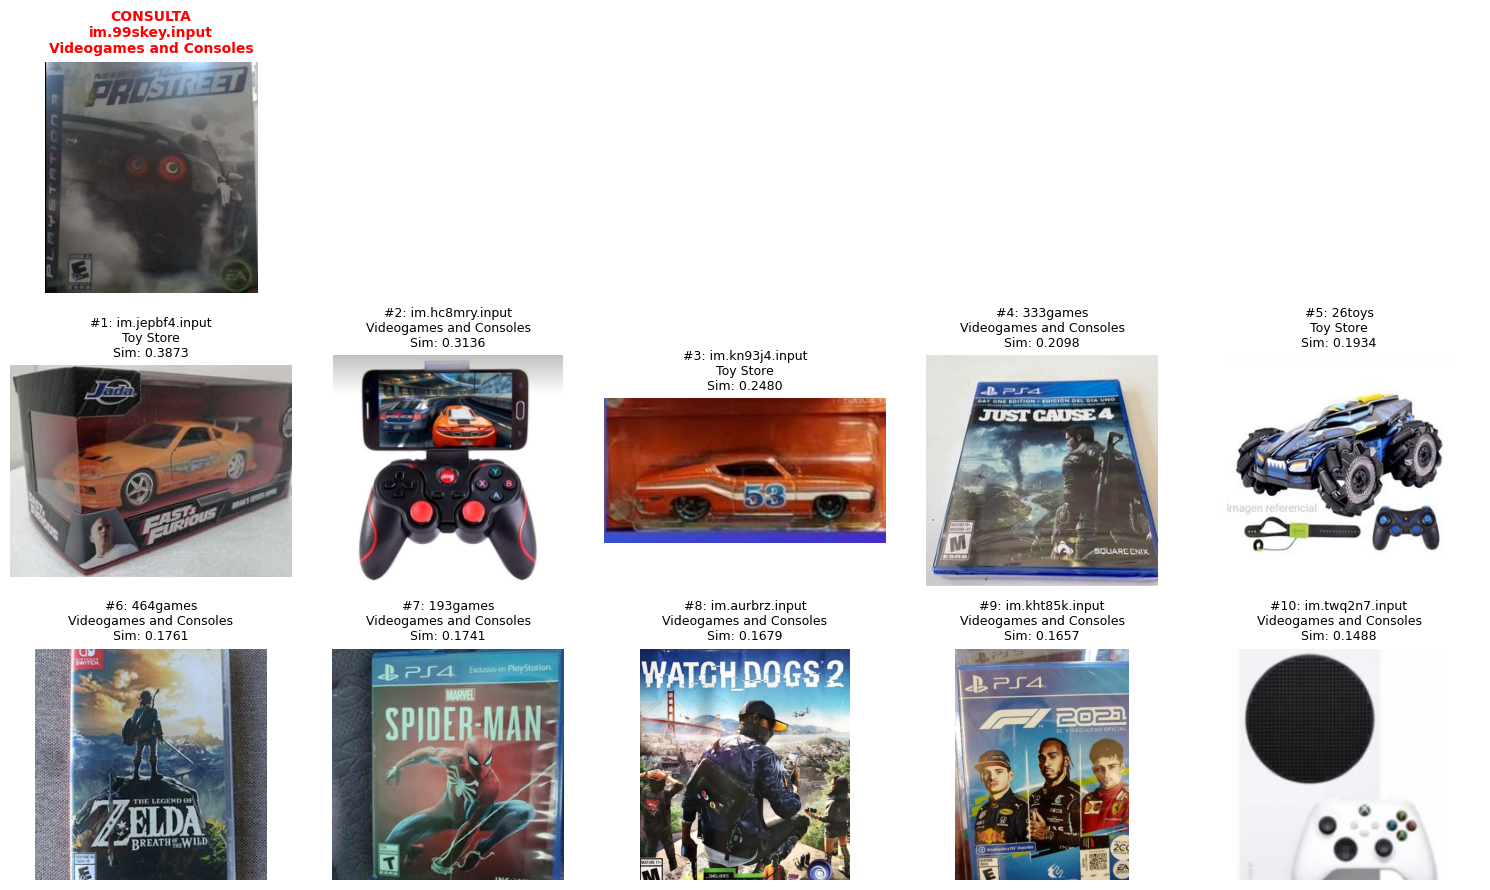

In [ ]:
# Ejemplo: Recuperar imágenes similares para una consulta aleatoria
random_idx = random.randint(0, len(valid_filenames) - 1)
display_retrieval_results(random_idx, top_k=10)

## Parte 8: Evaluación con Precisión Media Promedio (MAP)

**Mean Average Precision (MAP)** o Precisión Media Promedio es una métrica utilizada para evaluar la calidad de resultados de recuperación ordenados. Es particularmente útil para sistemas de recuperación de imágenes donde queremos medir qué tan bien nuestro codificador encuentra imágenes relevantes. (A diferencia de la precisión simple, MAP recompensa sistemas que clasifican elementos relevantes más alto, y evalúa toda la lista ordenada, no solo el top-K)

### Clave:

1. **Relevancia**: En nuestro caso, dos imágenes se consideran "relevantes" si pertenecen a la **misma categoría** (ej., ambas son juguetes)

2. **Precisión en K (P@K)**: La proporción de elementos relevantes en los K resultados recuperados
   - Ejemplo: Si recuperamos 10 imágenes y 7 son de la misma categoría que la consulta, P@10 = 0.7

3. **Precisión Promedio (AP)**: Para una sola consulta, AP es el promedio de los valores de precisión calculados en cada posición donde se encuentra un elemento relevante
   - Fórmula: $AP = \frac{1}{R} \sum_{k=1}^{N} P(k) \times rel(k)$
   - Donde $R$ es el número total de elementos relevantes, $N$ es el número de elementos recuperados, $P(k)$ es la precisión en la posición $k$, y $rel(k)$ es 1 si el elemento en la posición $k$ es relevante, 0 en caso contrario

4. **Precisión Media Promedio (MAP)**: La media de AP a través de todas las consultas
   - $MAP = \frac{1}{Q} \sum_{q=1}^{Q} AP(q)$
   - Donde $Q$ es el número total de consultas


### Implementación: Función de Precisión Promedio

Implementemos el cálculo de Precisión Promedio para una sola consulta.

In [ ]:
def compute_average_precision(query_idx, k=None):
    """
    Calcula la Precisión Promedio para una sola consulta.

    Args:
        query_idx: Índice de la imagen de consulta
        k: Número de resultados top a considerar (None = todos los resultados)

    Returns:
        ap: Puntuación de Precisión Promedio
        num_relevant: Número total de elementos relevantes en el conjunto de datos
    """

    # Obtener categoría de la consulta
    query_filename = valid_filenames[query_idx]
    query_category = df[df['Title'] == query_filename]['GlobalCategoryEN'].values[0]

    # Obtener todas las categorías
    categories = [df[df['Title'] == fn]['GlobalCategoryEN'].values[0]
                  for fn in valid_filenames]

    # Encontrar todas las imágenes relevantes (misma categoría, excluyendo la consulta)
    relevant_mask = np.array([cat == query_category for cat in categories])
    relevant_mask[query_idx] = False  # Excluir la imagen de consulta misma
    num_relevant = relevant_mask.sum()

    if num_relevant == 0:
        return 0.0, 0

    # Obtener lista ordenada de imágenes recuperadas
    similarities = similarity_matrix[query_idx]
    ranked_indices = np.argsort(similarities)[::-1]

    # Remover imagen de consulta de la lista ordenada
    ranked_indices = ranked_indices[ranked_indices != query_idx]

    # Limitar a top K si se especifica
    if k is not None:
        ranked_indices = ranked_indices[:k]

    # Calcular Precisión Promedio
    precision_sum = 0.0
    num_relevant_seen = 0

    for i, idx in enumerate(ranked_indices):
        if relevant_mask[idx]:  # Si este elemento recuperado es relevante
            num_relevant_seen += 1
            precision_at_i = num_relevant_seen / (i + 1)
            precision_sum += precision_at_i

    # Promediar sobre todos los elementos relevantes
    average_precision = precision_sum / num_relevant

    return average_precision, num_relevant

In [ ]:
# Probar cálculo de AP en un solo ejemplo
test_idx = 0  # Primera imagen en el conjunto de datos
ap, num_rel = compute_average_precision(test_idx, k=100)
test_filename = valid_filenames[test_idx]
test_category = df[df['Title'] == test_filename]['GlobalCategoryEN'].values[0]

print(f"Ejemplo de Cálculo de AP:")
print(f"  Consulta: {test_filename} (Categoría: {test_category})")
print(f"  Número de imágenes relevantes en el conjunto: {num_rel}")
print(f"  Precisión Promedio (AP@100): {ap:.4f}")
print(f"\nInterpretación:")
print(f"  - AP = 1.0 significa que todos los elementos relevantes están al principio")
print(f"  - AP = 0.0 significa que no se encontraron elementos relevantes")
print(f"  - Mayor AP = mejor calidad de recuperación")

Ejemplo de Cálculo de AP:
  Consulta: 14toys (Categoría: Toy Store)
  Número de imágenes relevantes en el conjunto: 53
  Precisión Promedio (AP@100): 0.1912

Interpretación:
  - AP = 1.0 significa que todos los elementos relevantes están al principio
  - AP = 0.0 significa que no se encontraron elementos relevantes
  - Mayor AP = mejor calidad de recuperación


### Calculando MAP a Través de Todas las Consultas

Ahora calculemos MAP promediando las puntuaciones de AP a través de todas las imágenes en nuestro conjunto de datos. Esto nos da una sola métrica para evaluar el rendimiento general de nuestro codificador DinoV2 para recuperación de imágenes.

In [ ]:
def compute_map(k=None):
    """
    Calcula la Precisión Media Promedio a través de todas las consultas.

    Args:
        k: Número de resultados top a considerar para cada consulta (None = todos)

    Returns:
        map_score: Precisión Media Promedio
        ap_scores: Lista de puntuaciones AP individuales para cada consulta
    """
    ap_scores = []

    print(f"Calculando MAP@{k if k else 'Todos'}...")
    for query_idx in tqdm(range(len(valid_filenames))):
        ap, _ = compute_average_precision(query_idx, k=k)
        ap_scores.append(ap)

    map_score = np.mean(ap_scores)
    return map_score, ap_scores

# Calcular MAP en diferentes valores de K
k_values = [10, 50, 100, 200, None]  # None significa considerar todos los resultados
map_results = {}

for k in k_values:
    map_score, ap_scores = compute_map(k=k)
    map_results[k] = {
        'MAP': map_score,
        'AP_scores': ap_scores
    }
    k_label = k if k else 'Todos'
    print(f"\nMAP@{k_label}: {map_score:.4f}")

print("\n" + "="*80)
print("Resumen MAP:")
print("="*80)
for k in k_values:
    k_label = k if k else 'Todos'
    print(f"  MAP@{k_label}: {map_results[k]['MAP']:.4f}")

Calculando MAP@10...


100%|██████████| 300/300 [00:24<00:00, 12.05it/s]



MAP@10: 0.1903
Calculando MAP@50...


100%|██████████| 300/300 [00:24<00:00, 12.11it/s]



MAP@50: 0.3141
Calculando MAP@100...


100%|██████████| 300/300 [00:25<00:00, 11.90it/s]



MAP@100: 0.3519
Calculando MAP@200...


100%|██████████| 300/300 [00:25<00:00, 11.87it/s]



MAP@200: 0.3880
Calculando MAP@Todos...


100%|██████████| 300/300 [00:27<00:00, 10.81it/s]


MAP@Todos: 0.4068

Resumen MAP:
  MAP@10: 0.1903
  MAP@50: 0.3141
  MAP@100: 0.3519
  MAP@200: 0.3880
  MAP@Todos: 0.4068


### Visualizando Resultados de MAP

Visualicemos la distribución de puntuaciones de Precisión Promedio para entender qué tan bien funciona el codificador a través de diferentes categorías.

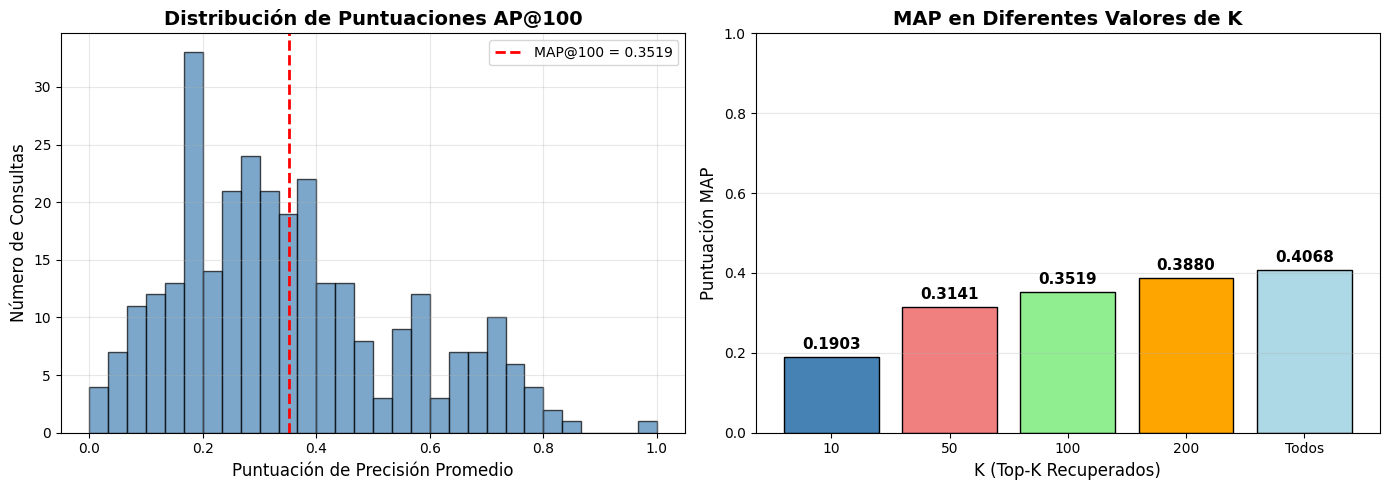


Observaciones:
  - Puntuaciones MAP más altas indican mejor calidad de recuperación
  - MAP@K típicamente aumenta con K (más oportunidades de encontrar elementos relevantes)


In [ ]:
# Graficar histograma de puntuaciones AP
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de puntuaciones AP@100
ap_scores_100 = map_results[100]['AP_scores']
axes[0].hist(ap_scores_100, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(map_results[100]['MAP'], color='red', linestyle='--', linewidth=2, label=f'MAP@100 = {map_results[100]["MAP"]:.4f}')
axes[0].set_xlabel('Puntuación de Precisión Promedio', fontsize=12)
axes[0].set_ylabel('Número de Consultas', fontsize=12)
axes[0].set_title('Distribución de Puntuaciones AP@100', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Comparar MAP en diferentes valores de K
k_labels = ['10', '50', '100', '200', 'Todos']
map_scores = [map_results[k]['MAP'] for k in k_values]
axes[1].bar(k_labels, map_scores, color=['steelblue', 'lightcoral', 'lightgreen', 'orange','lightblue'], edgecolor='black')
axes[1].set_xlabel('K (Top-K Recuperados)', fontsize=12)
axes[1].set_ylabel('Puntuación MAP', fontsize=12)
axes[1].set_title('MAP en Diferentes Valores de K', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Agregar etiquetas de valores en las barras
for i, (label, score) in enumerate(zip(k_labels, map_scores)):
    axes[1].text(i, score + 0.02, f'{score:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nObservaciones:")
print("  - Puntuaciones MAP más altas indican mejor calidad de recuperación")
print("  - MAP@K típicamente aumenta con K (más oportunidades de encontrar elementos relevantes)")

### Análisis de MAP por Categoría

Analicemos qué tan bien funciona el codificador para cada categoría de producto. Algunas categorías pueden ser más fáciles de recuperar que otras.

In [ ]:
# Calcular MAP por categoría
categories = [df[df['Title'] == fn]['GlobalCategoryEN'].values[0] for fn in valid_filenames]
unique_categories = sorted(set(categories))
category_map = {}
category_counts = {}

print(unique_categories)
print(f"Calculando MAP por categoría... (Total: {len(unique_categories)} categorías únicas)\n")

for category in unique_categories:
    # Encontrar todas las imágenes en esta categoría
    category_indices = [i for i, cat in enumerate(categories) if cat == category]
    category_counts[category] = len(category_indices)

    # Calcular AP para cada imagen en esta categoría
    ap_scores = []
    for idx in category_indices:
        ap, _ = compute_average_precision(idx, k=100)
        ap_scores.append(ap)

    # AP promedio para esta categoría
    category_map[category] = np.mean(ap_scores)
    print(f"  {category:25s}: MAP@100 = {category_map[category]:.4f} (n={len(category_indices)} imágenes)")

print("\n" + "="*80)
print(f"MAP@100 General: {map_results[100]['MAP']:.4f}")
print("="*80)

['Babies', 'Beauty', 'Bedroom', 'Christmas Decoration', 'Clothes and Shoes', 'Foods and Drinks', 'Furniture', 'Home', 'Home Appliances', 'Pets', 'School', 'Sports', 'Technology', 'Toy Store', 'Videogames and Consoles']
Calculando MAP por categoría... (Total: 15 categorías únicas)

  Babies                   : MAP@100 = 0.3870 (n=12 imágenes)
  Beauty                   : MAP@100 = 0.2427 (n=8 imágenes)
  Bedroom                  : MAP@100 = 0.6205 (n=4 imágenes)
  Christmas Decoration     : MAP@100 = 0.6228 (n=4 imágenes)
  Clothes and Shoes        : MAP@100 = 0.4062 (n=27 imágenes)
  Foods and Drinks         : MAP@100 = 0.0000 (n=1 imágenes)
  Furniture                : MAP@100 = 0.2736 (n=13 imágenes)
  Home                     : MAP@100 = 0.2753 (n=35 imágenes)
  Home Appliances          : MAP@100 = 0.0000 (n=1 imágenes)
  Pets                     : MAP@100 = 0.5172 (n=31 imágenes)
  School                   : MAP@100 = 0.4336 (n=8 imágenes)
  Sports                   : MAP@100 = 0.2

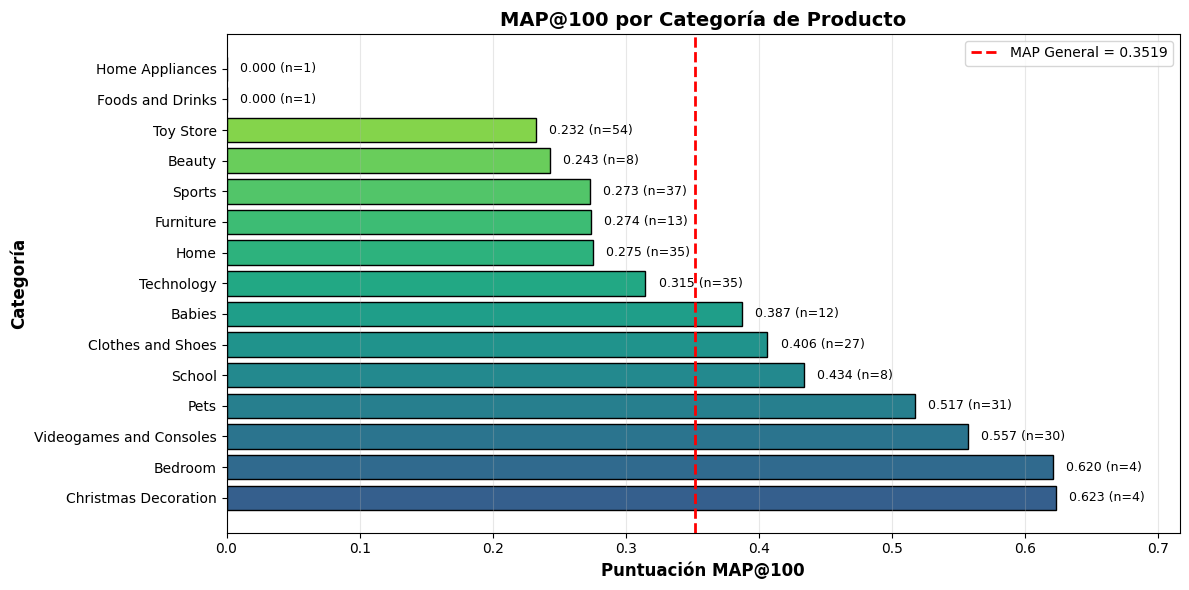


Observaciones:
  - Categorías con MAP más alto tienen características visuales más distintivas
  - Categorías con MAP más bajo pueden tener más diversidad visual dentro de la categoría
  - El tamaño de muestra (n) puede afectar la confiabilidad del MAP


In [ ]:
# Visualizar MAP por categoría
fig, ax = plt.subplots(figsize=(12, 6))

categories_sorted = sorted(category_map.items(), key=lambda x: x[1], reverse=True)
cat_names = [c[0] for c in categories_sorted]
cat_scores = [c[1] for c in categories_sorted]
cat_counts = [category_counts[c[0]] for c in categories_sorted]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(cat_names)))
bars = ax.barh(cat_names, cat_scores, color=colors, edgecolor='black')

# Agregar etiquetas de conteo
for i, (bar, count) in enumerate(zip(bars, cat_counts)):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.3f} (n={count})',
            va='center', fontsize=9)

ax.set_xlabel('Puntuación MAP@100', fontsize=12, fontweight='bold')
ax.set_ylabel('Categoría', fontsize=12, fontweight='bold')
ax.set_title('MAP@100 por Categoría de Producto', fontsize=14, fontweight='bold')
ax.set_xlim([0, max(cat_scores) * 1.15])
ax.axvline(map_results[100]['MAP'], color='red', linestyle='--', linewidth=2,
           label=f'MAP General = {map_results[100]["MAP"]:.4f}')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservaciones:")
print("  - Categorías con MAP más alto tienen características visuales más distintivas")
print("  - Categorías con MAP más bajo pueden tener más diversidad visual dentro de la categoría")
print("  - El tamaño de muestra (n) puede afectar la confiabilidad del MAP")

### Ejemplo Detallado: Entendiendo el Cálculo de AP

Veamos un ejemplo concreto paso a paso para entender cómo se calcula la Precisión Promedio.

In [ ]:
def compute_ap_detailed(query_idx, k=20):
    """
    Calcula AP con explicación detallada paso a paso.
    """
    # Obtener información de la consulta
    query_filename = valid_filenames[query_idx]
    query_category = df[df['Title'] == query_filename]['GlobalCategoryEN'].values[0]

    # Obtener todas las categorías
    categories = [df[df['Title'] == fn]['GlobalCategoryEN'].values[0]
                  for fn in valid_filenames]

    # Encontrar imágenes relevantes
    relevant_mask = np.array([cat == query_category for cat in categories])
    relevant_mask[query_idx] = False
    num_relevant_total = relevant_mask.sum()

    # Obtener resultados ordenados
    similarities = similarity_matrix[query_idx]
    ranked_indices = np.argsort(similarities)[::-1]
    ranked_indices = ranked_indices[ranked_indices != query_idx][:k]

    # Calcular AP paso a paso
    print(f"Imagen de Consulta: {query_filename} (Categoría: {query_category})")
    print(f"Total de imágenes relevantes en el conjunto: {num_relevant_total}")
    print(f"\nTop {k} Imágenes Recuperadas:")
    print("="*100)
    print(f"{'Rango':<6} {'Nombre':<20} {'Categoría':<25} {'Similitud':<12} {'¿Relevante?':<10} {'Precisión@k':<12}")
    print("="*100)

    precision_sum = 0.0
    num_relevant_seen = 0
    precisions_at_relevant = []

    for i, idx in enumerate(ranked_indices):
        filename = valid_filenames[idx]
        category = categories[idx]
        sim = similarities[idx]
        is_relevant = relevant_mask[idx]

        if is_relevant:
            num_relevant_seen += 1
            precision_at_i = num_relevant_seen / (i + 1)
            precision_sum += precision_at_i
            precisions_at_relevant.append(precision_at_i)
            relevant_mark = "✓ SÍ"
        else:
            precision_at_i = num_relevant_seen / (i + 1)
            relevant_mark = "✗ No"

        print(f"{i+1:<6} {filename:<20} {category:<25} {sim:<12.4f} {relevant_mark:<10} {precision_at_i:.4f}")

    ap = precision_sum / num_relevant_total

    print("="*100)
    print(f"\nCálculo de Precisión Promedio:")
    print(f"  Suma de precisiones en posiciones relevantes: {precision_sum:.4f}")
    print(f"  Total de elementos relevantes en el conjunto: {num_relevant_total}")
    print(f"  Precisión Promedio (AP@{k}): {precision_sum:.4f} / {num_relevant_total} = {ap:.4f}")

    if precisions_at_relevant:
        print(f"\n  Precisiones en posiciones relevantes: {[f'{p:.4f}' for p in precisions_at_relevant]}")

    return ap

# Mostrar ejemplo detallado
example_idx = random.randint(0, len(valid_filenames) - 1)
ap_detailed = compute_ap_detailed(example_idx, k=20)

Imagen de Consulta: 141ent (Categoría: School)
Total de imágenes relevantes en el conjunto: 7

Top 20 Imágenes Recuperadas:
Rango  Nombre               Categoría                 Similitud    ¿Relevante? Precisión@k 
1      134ent               School                    0.3420       ✓ SÍ       1.0000
2      464games             Videogames and Consoles   0.2321       ✗ No       0.5000
3      10ent                School                    0.2119       ✓ SÍ       0.6667
4      193games             Videogames and Consoles   0.1800       ✗ No       0.5000
5      im.hcj9nt.input      Toy Store                 0.1691       ✗ No       0.4000
6      304games             Videogames and Consoles   0.1373       ✗ No       0.3333
7      24elec               Technology                0.1273       ✗ No       0.2857
8      im.99skey.input      Videogames and Consoles   0.1263       ✗ No       0.2500
9      im.dhcesv.input      Toy Store                 0.1262       ✗ No       0.2222
10     im.v8ucq8.in

## Resumen y Conclusiones Clave

### Lo que logramos:

1. **Codificación de Imágenes**: Usamos DinoV2 para convertir imágenes en vectores de características de 384 dimensiones
2. **Cálculo de Similitud**: Calculamos la similitud coseno entre todos los pares de imágenes
3. **Recuperación de Imágenes**: Implementamos un sistema para encontrar las imágenes más similares a cualquier consulta
4. **Evaluación**: Usamos MAP para medir cuantitativamente la calidad de recuperación

### Por qué MAP es importante:

- **Evaluación cuantitativa**: Proporciona un solo número para comparar diferentes codificadores
- **Consciente del ranking**: Recompensa sistemas que colocan elementos relevantes al principio
- **Relevancia basada en categorías**: En nuestro caso, elementos de la misma categoría se consideran relevantes
- **Métrica estándar**: Ampliamente utilizada en investigación académica e industria para sistemas de recuperación

## DinoV3


In [ ]:
# Cargar el modelo DinoV3 desde torch hub
# https://github.com/facebookresearch/dinov3

!gdown --id 1-LqJ2bS_T8XOx5TClDq31MCkPPoXO4bZ
!unzip dinov3-main.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-LqJ2bS_T8XOx5TClDq31MCkPPoXO4bZ
To: /content/dinov3-main.zip
100% 10.3M/10.3M [00:00<00:00, 37.6MB/s]
Archive:  dinov3-main.zip
adc254450203739c8149213a7a69d8d905b4fcfa
   creating: dinov3-main/
  inflating: dinov3-main/.docstr.yaml  
   creating: dinov3-main/.github/
   creating: dinov3-main/.github/workflows/
  inflating: dinov3-main/.github/workflows/lint.yaml  
  inflating: dinov3-main/.gitignore  
  inflating: dinov3-main/CODE_OF_CONDUCT.md  
  inflating: dinov3-main/CONTRIBUTING.md  
  inflating: dinov3-main/LICENSE.md  
  inflating: dinov3-main/MODEL_CARD.md  
  inflating: dinov3-main/README.md   
  inflating: dinov3-main/conda.yaml  
   creating: dinov3-main/dinov3/
  inflating: dinov3-main/dinov3/__init__.p

In [ ]:
# DINOv3 ViT models pretrained on web images
# !gdown --id 1fH2rq53x6JY6zE_WBKH5vP_ZGq4jvj46
# dinov3_vits16plus = torch.hub.load(REPO_DIR, 'dinov3_vits16plus', source='local', weights=Path('dinov3_vits16plus_pretrain_lvd1689m-4057cbaa.pth'))

# !gdown --id 1Fznrc_pDwp7iaUBhAoWUKPI1vsGpHy8m
# dinov3_vitb16 = torch.hub.load(REPO_DIR, 'dinov3_vitb16', source='local', weights=Path('dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth'))

# !gdown --id 1CfyML_a7PkVpt4Lhy-3yNxSfUgsFfgCs
dinov3_vitl16 = torch.hub.load(repo_or_dir='./dinov3-main',model='dinov3_vitl16', source='local', weights='dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth')
dinov3_vitl16 = dinov3_vitl16.to(device)
dinov3_vitl16.eval()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-23): 24 x SelfAttentionBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm)

In [ ]:
# Definir la transformación de preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def encode_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = dinov3_vitl16(img_tensor)

    return features.cpu().numpy().flatten()

print(encode_image(data_dir / '14toys.jpg').shape)